# Чтобы нормально закомпайлить не забудьте установить версию sklearn именно 1.2.2, также нужно установить optuna

In [ ]:
%pip install optuna

In [34]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, fbeta_score
from imblearn.over_sampling import SMOTE
import optuna
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

## Создание функции для скоров

In [35]:
def print_scores(y_true, y_pred):
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred))
    print("CONFUSION MATRIX: ", confusion_matrix(y_true, y_pred))

In [36]:
df = pd.read_csv('training_data.csv', index_col=0) 

# Описание задания

Вам необходимо построить модель-классификатор по определению диабета. У вас нет никаких ограничений по инструментам, новым полям и способу энкодинга данных.

In [37]:
df

,ID,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,78830894-cdd8-43d1-9655-03db74141b7a,Female,80.0,0,1,never,25.19,6.6,140,0
1,32262c0e-903a-46b8-9061-b1a2f5a3e9b2,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,c4868b73-ca90-48ed-af14-3d1f78a5f030,Male,28.0,0,0,never,27.32,5.7,158,0
3,bec2ef91-5aff-48df-ac16-cb210b5f29fa,Female,36.0,0,0,current,23.45,5.0,155,0
4,1a6852a8-ee80-4d93-bea0-f0cdd941dc3d,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...,...
73713,5c890971-a6d7-44ce-a8a1-3b38cda7ef3b,Female,70.0,1,0,never,55.57,6.2,130,1
73714,13a8f177-1623-4acf-9db8-1e8ac8577c86,Male,60.0,0,0,No Info,27.32,6.6,160,0
73715,c9539d1b-075f-481f-8ae4-ab9bba75af5b,Male,65.0,0,0,former,32.07,5.0,160,0
73716,08eb5a8d-f577-440a-9408-c6d99ca17204,Male,64.0,0,0,current,30.23,6.2,158,0


In [38]:
df_copy = df.copy(deep=True)

In [39]:
df_copy.shape

(73718, 10)

## Удаление дупликатов

In [40]:
df_copy.duplicated().sum()

3718

In [41]:
df_copy = df_copy.drop_duplicates()

In [42]:
df_copy.shape

(70000, 10)

## Проверка на NA

In [43]:
df_copy.isna().sum()

ID                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

## Проверка на пустоты

In [44]:
df_copy.isnull().sum()

ID                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

## Проверка базы

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73718 entries, 0 to 73717
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   73718 non-null  object 
 1   gender               73718 non-null  object 
 2   age                  73718 non-null  float64
 3   hypertension         73718 non-null  int64  
 4   heart_disease        73718 non-null  int64  
 5   smoking_history      73718 non-null  object 
 6   bmi                  73718 non-null  float64
 7   HbA1c_level          73718 non-null  float64
 8   blood_glucose_level  73718 non-null  int64  
 9   diabetes             73718 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 6.2+ MB


## Encoding категориальный даты

In [46]:
ohe = OneHotEncoder()
ohe_df = ohe.fit_transform(df_copy[['gender', 'smoking_history']])
ohe_df = pd.DataFrame(ohe_df.toarray(), columns=ohe.get_feature_names_out())
ohe_df

,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
69995,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
69996,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
69998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
df_copy = pd.concat([df_copy, ohe_df], axis=1)

In [48]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 69999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           70000 non-null  object 
 1   gender                       70000 non-null  object 
 2   age                          70000 non-null  float64
 3   hypertension                 70000 non-null  int64  
 4   heart_disease                70000 non-null  int64  
 5   smoking_history              70000 non-null  object 
 6   bmi                          70000 non-null  float64
 7   HbA1c_level                  70000 non-null  float64
 8   blood_glucose_level          70000 non-null  int64  
 9   diabetes                     70000 non-null  int64  
 10  gender_Female                70000 non-null  float64
 11  gender_Male                  70000 non-null  float64
 12  gender_Other                 70000 non-null  float64
 13  smoking_history_No In

## Дропаем ненужные колонны 

In [49]:
df_copy = df_copy.drop(['ID', "gender", 'smoking_history'], axis=1)
df_copy

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,54.0,0,0,27.32,6.6,80,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,28.0,0,0,27.32,5.7,158,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36.0,0,0,23.45,5.0,155,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,76.0,1,1,20.14,4.8,155,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,36.0,0,0,24.60,4.8,145,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
69996,2.0,0,0,17.37,6.5,100,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
69997,66.0,0,0,27.83,5.7,155,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
69998,24.0,0,0,35.42,4.0,100,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [50]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 69999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          70000 non-null  float64
 1   hypertension                 70000 non-null  int64  
 2   heart_disease                70000 non-null  int64  
 3   bmi                          70000 non-null  float64
 4   HbA1c_level                  70000 non-null  float64
 5   blood_glucose_level          70000 non-null  int64  
 6   diabetes                     70000 non-null  int64  
 7   gender_Female                70000 non-null  float64
 8   gender_Male                  70000 non-null  float64
 9   gender_Other                 70000 non-null  float64
 10  smoking_history_No Info      70000 non-null  float64
 11  smoking_history_current      70000 non-null  float64
 12  smoking_history_ever         70000 non-null  float64
 13  smoking_history_forme

## Деление на таргет и на фичи

In [51]:
feature_names = df_copy.drop(columns='diabetes').columns
X = df_copy.drop(columns=['diabetes']).values
y = df_copy['diabetes']

In [52]:
X.shape

(70000, 15)

In [53]:
y.shape

(70000,)

## Проверка коррелляции

<Axes: >

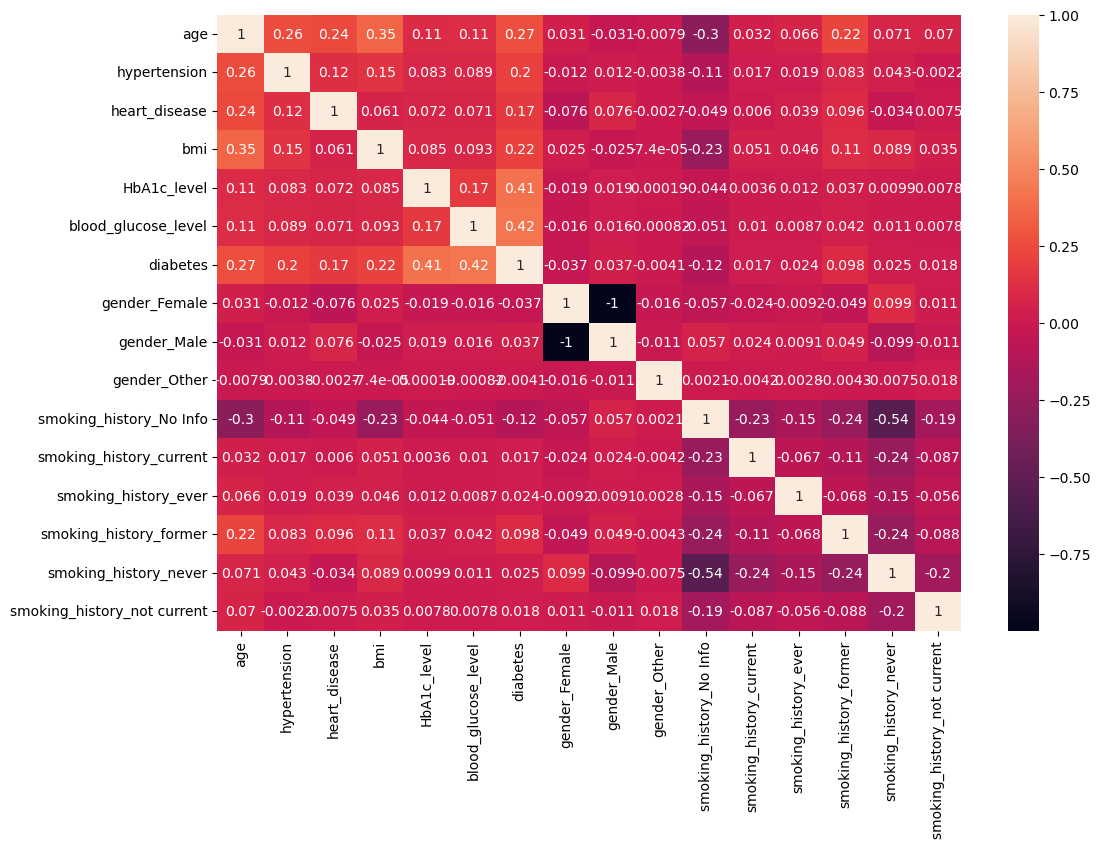

In [54]:
plt.figure(figsize=(12,8))
sns.heatmap(df_copy.corr(), annot=True)

# Test-split (test_size = 0.3 лучшее по интернет источникам)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Использую СМОУТ чтобы улучшить соотнешения данных

## Решил не использовать, поскольку СМОУТ ломает feature correlations и поэтому не использую


# Использую Optuna для тюнинга моделей

In [56]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 8)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2,20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None, 0.5, 0.7])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    model = DecisionTreeClassifier(max_depth=max_depth, 
                                   min_samples_leaf=min_samples_leaf, 
                                   min_samples_split=min_samples_split, 
                                   max_features=max_features, 
                                   criterion=criterion, 
                                   splitter=splitter, 
                                   class_weight=class_weight)
    model.fit(X_train, y_train)
    return fbeta_score(y_test, model.predict(X_test), beta=1.6)

In [57]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=43))

[I 2024-03-01 00:52:54,881] A new study created in memory with name: no-name-8b327378-d5cb-471c-9e0d-baa688e9ec24


In [58]:
study.optimize(objective, n_trials=2000)

[I 2024-03-01 00:52:55,416] Trial 0 finished with value: 0.3389564146308659 and parameters: {'max_depth': 1, 'min_samples_leaf': 13, 'min_samples_split': 4, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.3389564146308659.
[I 2024-03-01 00:52:55,440] Trial 1 finished with value: 0.26002913884582124 and parameters: {'max_depth': 2, 'min_samples_leaf': 9, 'min_samples_split': 8, 'max_features': None, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 0 with value: 0.3389564146308659.
[I 2024-03-01 00:52:55,452] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 1, 'min_samples_leaf': 11, 'min_samples_split': 11, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 0 with value: 0.3389564146308659.
[I 2024-03-01 00:52:55,465] Trial 3 finished with value: 0.5432511164450395 and parameters: {'max_depth': 3, 'min_samples

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:52:55,977] Trial 26 finished with value: 0.5214532049491036 and parameters: {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 12, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7386728481408948.
[I 2024-03-01 00:52:56,000] Trial 27 finished with value: 0.6082054752688527 and parameters: {'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split': 5, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7386728481408948.
[I 2024-03-01 00:52:56,013] Trial 28 finished with value: 0.5024183185827932 and parameters: {'max_depth': 3, 'min_samples_lea

[I 2024-03-01 00:52:56,582] Trial 52 finished with value: 0.4600390138097618 and parameters: {'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 11, 'max_features': None, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 14 with value: 0.7386728481408948.
[I 2024-03-01 00:52:56,597] Trial 53 finished with value: 0.47255608829054935 and parameters: {'max_depth': 3, 'min_samples_leaf': 19, 'min_samples_split': 7, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7386728481408948.
[I 2024-03-01 00:52:56,619] Trial 54 finished with value: 0.6544607439562907 and parameters: {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 11, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7386728481408948.
[I 2024-03-01 00:52:56,645] Trial 55 finished with value: 0.6281118133741178 and parameters:

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:52:57,007] Trial 75 finished with value: 0.7386728481408948 and parameters: {'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 19, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 14 with value: 0.7386728481408948.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:52:57,015] Trial 76 finished with value: 0.0 and parameters: {'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 13, 'max_features': 'a

[I 2024-03-01 00:52:57,497] Trial 99 finished with value: 0.7386728481408948 and parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 17, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 14 with value: 0.7386728481408948.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:52:57,514] Trial 100 finished with value: 0.5305155636487794 and parameters: {'max_depth': 7, 'min_samples_leaf': 16, 'min_samples_split': 11, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 14 with value: 0.7386728481408948.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` h

[I 2024-03-01 00:52:57,895] Trial 122 finished with value: 0.3349307466413856 and parameters: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 9, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 119 with value: 0.7408248202799849.
[I 2024-03-01 00:52:57,913] Trial 123 finished with value: 0.5085697959236086 and parameters: {'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 18, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 119 with value: 0.7408248202799849.
[I 2024-03-01 00:52:57,930] Trial 124 finished with value: 0.6091050024577457 and parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 4, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 119 with value: 0.7408248202799849.
[I 2024-03-01 00:52:57,956] Trial 125 finished with value: 0.6424753402766298 and par

[I 2024-03-01 00:52:58,320] Trial 144 finished with value: 0.7395662983792695 and parameters: {'max_depth': 8, 'min_samples_leaf': 14, 'min_samples_split': 8, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:52:58,334] Trial 145 finished with value: 0.3736264594275245 and parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:52:58,350] Trial 146 finished with value: 0.6252927400468383 and parameters: {'max_depth': 3, 'min_samples_leaf': 13, 'min_samples_split': 16, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWa

[I 2024-03-01 00:52:58,730] Trial 168 finished with value: 0.5357119906319839 and parameters: {'max_depth': 1, 'min_samples_leaf': 15, 'min_samples_split': 18, 'max_features': None, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:52:58,751] Trial 169 finished with value: 0.5939524233023579 and parameters: {'max_depth': 3, 'min_samples_leaf': 14, 'min_samples_split': 20, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:52:58,771] Trial 170 finished with value: 0.42741750889178437 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 20, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:52:58,787] Trial 171 finished with value: 0.5579322719950803 and parameters: {'max_de

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:52:59,140] Trial 191 finished with value: 0.7386728481408948 and parameters: {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 12, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:52:59,178] Trial 192 finished with value: 0.7386728481408948 and parameters: {'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 6, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:52:59,200] Trial 193 finished with value: 0.6453252677688799 and parameters: {'max_depth': 7, 'min_samples_leaf': 19, 'min

[I 2024-03-01 00:52:59,578] Trial 215 finished with value: 0.506704737094082 and parameters: {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 13, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:52:59,628] Trial 216 finished with value: 0.7386728481408948 and parameters: {'max_depth': 7, 'min_samples_leaf': 16, 'min_samples_split': 19, 'max_features': None, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:52:59,647] Trial 217 finished with value: 0.6718194898091387 and parameters: {'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:52:59,666] Trial 218 finished with value: 0.659367296911595 and parameters: {'ma

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:00,280] Trial 242 finished with value: 0.4522334952963588 and parameters: {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:00,293] Trial 243 finished with value: 0.0 and parameters: {'max_depth': 1, 'min_samples_leaf': 14, 'min_samples_split': 17, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:00,333] Trial 244 finished with value: 0.7386728481408948 and parameters: {'max_depth': 4, 'min_samples_leaf': 11, 'm

[I 2024-03-01 00:53:00,767] Trial 265 finished with value: 0.3670196873918924 and parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 8, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:00,789] Trial 266 finished with value: 0.5762970170932222 and parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:00,804] Trial 267 finished with value: 0.46048021018588875 and parameters: {'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 12, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:00,834] Trial 268 finished with value: 0.5270985623072291 and p

[I 2024-03-01 00:53:01,214] Trial 289 finished with value: 0.0 and parameters: {'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 3, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:01,230] Trial 290 finished with value: 0.4182005227158984 and parameters: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 15, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:01,264] Trial 291 finished with value: 0.7313636090546791 and parameters: {'max_depth': 7, 'min_samples_leaf': 7, 'min_sa

[I 2024-03-01 00:53:01,636] Trial 311 finished with value: 0.446712535163965 and parameters: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 10, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:01,670] Trial 312 finished with value: 0.6174633654150746 and parameters: {'max_depth': 5, 'min_samples_leaf': 16, 'min_samples_split': 17, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:01,682] Trial 313 finished with value: 0.4260641800652603 and parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 11, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:01,698] Trial 314 finished with value: 0.5357119906319839 and param

[I 2024-03-01 00:53:02,088] Trial 337 finished with value: 0.6050026399155226 and parameters: {'max_depth': 4, 'min_samples_leaf': 11, 'min_samples_split': 7, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:02,101] Trial 338 finished with value: 0.38851824396672435 and parameters: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:02,114] Trial 339 finished with value: 0.5639079620663769 and parameters: {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 4, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:02,123] Trial 340 finished with value: 0.0 and parameters: {'max_depth': 2,

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:02,691] Trial 363 finished with value: 0.4777538234485553 and parameters: {'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split': 5, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:02,705] Trial 364 finished with value: 0.4837198022838639 and parameters: {'max_depth': 7, 'min_samples_leaf': 14, 'min_samples_split': 18, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:02,730] Trial 365 finished with value: 0.7408248202799849 and parameters: {'max_depth': 7, 'min_samples_l

[I 2024-03-01 00:53:03,143] Trial 387 finished with value: 0.5429377585228317 and parameters: {'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 18, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:03,162] Trial 388 finished with value: 0.4988888941760924 and parameters: {'max_depth': 4, 'min_samples_leaf': 17, 'min_samples_split': 13, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:03,175] Trial 389 finished with value: 0.31581660827998004 and parameters: {'max_depth': 2, 'min_samples_leaf': 19, 'min_samples_split': 9, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_cla

[I 2024-03-01 00:53:03,670] Trial 412 finished with value: 0.5723154700314581 and parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 3, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:03,688] Trial 413 finished with value: 0.7093723710631191 and parameters: {'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 18, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:03,702] Trial 414 finished with value: 0.31854792798055453 and parameters: {'max_depth': 5, 'min_samples_leaf

[I 2024-03-01 00:53:04,101] Trial 435 finished with value: 0.48069342509310276 and parameters: {'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 15, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:04,111] Trial 436 finished with value: 0.18338198336012987 and parameters: {'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 18, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:04,125] Trial 437 finished with value: 0.47457676505725693 and parameters: {'max_depth': 3, 'min_samples_

[I 2024-03-01 00:53:04,554] Trial 461 finished with value: 0.7386728481408948 and parameters: {'max_depth': 5, 'min_samples_leaf': 11, 'min_samples_split': 8, 'max_features': None, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:04,584] Trial 462 finished with value: 0.532587172922338 and parameters: {'max_depth': 4, 'min_samples_leaf': 19, 'min_samples_split': 18, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:04,599] Trial 463 finished with value: 0.4225820549477412 and parameters: {'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 12, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:04,617] Trial 464 finished with value: 0.5577439570277529 and parameters: {'max

[I 2024-03-01 00:53:05,109] Trial 485 finished with value: 0.7474600200559455 and parameters: {'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 16, 'max_features': None, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:05,126] Trial 486 finished with value: 0.5425295267123035 and parameters: {'max_depth': 7, 'min_samples_leaf': 18, 'min_samples_split': 5, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:05,147] Trial 487 finished with value: 0.5005606407833783 and parameters: {'max_depth': 3, 'min_samples_leaf':

[I 2024-03-01 00:53:05,575] Trial 508 finished with value: 0.4243240842192544 and parameters: {'max_depth': 5, 'min_samples_leaf': 13, 'min_samples_split': 17, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:05,601] Trial 509 finished with value: 0.6663933978247801 and parameters: {'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 18, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:05,619] Trial 510 finished with value: 0.34152476045014857 and parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 16, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:05,631] Trial 511 finished with value: 0.2623353495655378 and parameters: {'max_dept

[I 2024-03-01 00:53:05,981] Trial 532 finished with value: 0.5617133054147965 and parameters: {'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 10, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:06,016] Trial 533 finished with value: 0.532587172922338 and parameters: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 3, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:06,059] Trial 534 finished with value: 0.7432593653066095 and parameters: {'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split': 20, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:06,080] Trial 535 finished with value: 0.5523553889196597 and parameters: {'max_d

[I 2024-03-01 00:53:06,469] Trial 555 finished with value: 0.3639889531110877 and parameters: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 12, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:06,489] Trial 556 finished with value: 0.46384146217673383 and parameters: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 14, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:06,524] Trial 557 finished with value: 0.6622786256775024 and parameters: {'max_depth': 7, 'min_samples_leaf': 16, 'min_samples_split': 4, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:06,537] Trial 558 finished with value: 0.45252344504394415 and parameters: 

[I 2024-03-01 00:53:07,052] Trial 582 finished with value: 0.6481775507386441 and parameters: {'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split': 10, 'max_features': None, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:07,073] Trial 583 finished with value: 0.6995271963145557 and parameters: {'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 13, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:07,090] Trial 584 finished with value: 0.5357119906319839 and parameters: {'max_depth': 1, 'min_samples_l

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:07,538] Trial 606 finished with value: 0.6876077687033002 and parameters: {'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 4, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:07,551] Trial 607 finished with value: 0.5427138542200945 and parameters: {'max_depth': 2, 'min_samples_leaf': 13, 'min_samples_split': 18, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:07,566] Trial 608 finished with value: 0.5903131266389018 and parameters: {'max_depth': 5, 'min_sampl

[I 2024-03-01 00:53:08,036] Trial 631 finished with value: 0.34640860084521363 and parameters: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 6, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:08,059] Trial 632 finished with value: 0.6724670325603036 and parameters: {'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 10, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:08,071] Trial 633 finished with value: 0.24777127842597516 and parameters: {'max_depth': 2, 'min_samples_l

[I 2024-03-01 00:53:08,480] Trial 654 finished with value: 0.10385064177362893 and parameters: {'max_depth': 2, 'min_samples_leaf': 11, 'min_samples_split': 8, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:08,505] Trial 655 finished with value: 0.6769257539952064 and parameters: {'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 15, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:08,515] Trial 656 finished with value: 0.0 and parameters: {'max_depth': 2, 'min_samples_leaf': 20, 'min_samples_split': 2, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:08,547] Trial 657 finished with value: 0.7386728481408948 and parameters: {'max_depth': 5, 'm

[I 2024-03-01 00:53:09,011] Trial 680 finished with value: 0.5519190393647635 and parameters: {'max_depth': 2, 'min_samples_leaf': 9, 'min_samples_split': 11, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:09,025] Trial 681 finished with value: 0.7130720008603537 and parameters: {'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 3, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:09,066] Trial 682 finished with value: 0.532587172922338 and parameters: {'max_depth': 4, 'min_samples_leaf': 17, 'min_samples_split': 4, 'max_features': None, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:09,096] Trial 683 finished with value: 0.7188011484075236 and parameters: {'max_de

[I 2024-03-01 00:53:09,643] Trial 707 finished with value: 0.0 and parameters: {'max_depth': 1, 'min_samples_leaf': 17, 'min_samples_split': 10, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:09,660] Trial 708 finished with value: 0.6579533154981927 and parameters: {'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 4, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:09,673] Trial 709 finished with value: 0.5357119906319839 and parameters: {'max_depth': 1, 'min_samples_leaf': 18, 'min_samples_split': 11, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features=

[I 2024-03-01 00:53:09,993] Trial 730 finished with value: 0.4683834424566244 and parameters: {'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 3, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:10,018] Trial 731 finished with value: 0.7386728481408948 and parameters: {'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 17, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:10,039] Trial 732 finished with value: 0.6871288197818811 and parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 11, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:10,055] Trial 733 finished with value: 0.34187552045558334 and parameters: {'max_depth'

[I 2024-03-01 00:53:10,514] Trial 755 finished with value: 0.4683834424566244 and parameters: {'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 19, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:10,547] Trial 756 finished with value: 0.7243123321673136 and parameters: {'max_depth': 6, 'min_samples_leaf': 14, 'min_samples_split': 17, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:10,558] Trial 757 finished with value: 0.5357119906319839 and parameters: {'max_depth': 1, 'min_samples_leaf': 13, 'min_samples_split': 15, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:10,574] Trial 758 finished with value: 0.597064728473393 and para

[I 2024-03-01 00:53:10,971] Trial 779 finished with value: 0.7386728481408948 and parameters: {'max_depth': 6, 'min_samples_leaf': 16, 'min_samples_split': 20, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:11,005] Trial 780 finished with value: 0.7386728481408948 and parameters: {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 18, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:11,015] Trial 781 finished with value: 0.0 and parameters: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_spli

[I 2024-03-01 00:53:11,501] Trial 804 finished with value: 0.5641680455901851 and parameters: {'max_depth': 8, 'min_samples_leaf': 17, 'min_samples_split': 13, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:11,513] Trial 805 finished with value: 0.1421404142737304 and parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 16, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:11,531] Trial 806 finished with value: 0.4505839780454716 and parameters: {'max_depth': 4, 'min_sample

[I 2024-03-01 00:53:11,931] Trial 827 finished with value: 0.6333623236422872 and parameters: {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 15, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:11,953] Trial 828 finished with value: 0.5506494504649911 and parameters: {'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split': 17, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:11,973] Trial 829 finished with value: 0.6059880976991524 and parameters: {'max_depth': 5, 'min_samples_leaf': 19, 'min_samples_split': 4, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:12,004] Trial 830 finished with value: 0.7386728481408948 and parameter

[I 2024-03-01 00:53:12,411] Trial 851 finished with value: 0.3509083648079709 and parameters: {'max_depth': 1, 'min_samples_leaf': 16, 'min_samples_split': 20, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:12,433] Trial 852 finished with value: 0.6064777944751074 and parameters: {'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 14, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:12,442] Trial 853 finished with value: 0.4683834424566244 and parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 20, 'max_features': None, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:12,483] Trial 854 finished with value: 0.532587172922338 and parameters: {'ma

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:12,974] Trial 875 finished with value: 0.3592572658772874 and parameters: {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 11, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:12,996] Trial 876 finished with value: 0.6829243602202786 and parameters: {'max_depth': 7, 'min_samples_leaf': 11, 'min_samples_split': 6, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:13,016] Trial 877 finished with value: 0.5934330699837508 and parameters: {'max_depth': 7, 'min_samples_leaf': 17,

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:13,415] Trial 899 finished with value: 0.4683834424566244 and parameters: {'max_depth': 5, 'min_samples_leaf': 14, 'min_samples_split': 7, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:13,472] Trial 900 finished with value: 0.700194214934329 and parameters: {'max_depth': 8, 'min_samples_leaf': 15, 'min_samples_split': 17, 'max_features': None, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:13,487] Trial 901 finished with value: 0.45912418117105513 and parameters: {'max_depth': 3, 'min_samples_le

[I 2024-03-01 00:53:13,889] Trial 922 finished with value: 0.7386728481408948 and parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:13,925] Trial 923 finished with value: 0.7386728481408948 and parameters: {'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 17, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 137 with value: 0.7479878281717228.
[I 2024-03-01 00:53:13,946] Trial 924 finished with value: 0.5546222142142642 and parameters: {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 18, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 137 with value: 0.7479878281717228.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: Futur

[I 2024-03-01 00:53:14,362] Trial 945 finished with value: 0.7386728481408948 and parameters: {'max_depth': 7, 'min_samples_leaf': 12, 'min_samples_split': 16, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:14,374] Trial 946 finished with value: 0.050877788916413286 and parameters: {'max_depth': 2, 'min_samples_leaf': 14, 'min_samples_split': 3, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:14,402] Trial 947 finished with value: 0.7386728481408948 and parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 16, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:14,447] Trial 948 finished with value: 0.6174633654150746 and parameters: {'max_depth':

[I 2024-03-01 00:53:14,862] Trial 969 finished with value: 0.37038421673557925 and parameters: {'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:14,919] Trial 970 finished with value: 0.700194214934329 and parameters: {'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_split': 10, 'max_features': None, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:14,945] Trial 971 finished with value: 0.6916971027525609 and parameters: {'max_depth': 8, 'min_sample

[I 2024-03-01 00:53:15,331] Trial 991 finished with value: 0.4683834424566244 and parameters: {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 6, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:15,355] Trial 992 finished with value: 0.5682884735124383 and parameters: {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 14, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:15,370] Trial 993 finished with value: 0.6000305818899606 and parameters: {'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 13, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:15,391] Trial 994 finished with value: 0.6913803496081977 and paramet

[I 2024-03-01 00:53:15,842] Trial 1015 finished with value: 0.7386728481408948 and parameters: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 20, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:15,860] Trial 1016 finished with value: 0.5357119906319839 and parameters: {'max_depth': 1, 'min_samples_leaf': 12, 'min_samples_split': 9, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:15,869] Trial 1017 finished with value: 0.0732655010043136 and parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 6, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:15,882] Trial 1018 finished with value: 0.39156398608943227 and parameters: {'max

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:16,204] Trial 1038 finished with value: 0.3504254163649529 and parameters: {'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 12, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:16,227] Trial 1039 finished with value: 0.6222972673097951 and parameters: {'max_depth': 7, 'min_samples_leaf': 11, 'min_samples_split': 6, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:16,240] Trial 1040 finished with value: 0.5357119906319839 and parameters: {'max_depth': 1, 'min_samples_l

[I 2024-03-01 00:53:16,630] Trial 1061 finished with value: 0.3529832324874318 and parameters: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 6, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:16,652] Trial 1062 finished with value: 0.6365640891363367 and parameters: {'max_depth': 8, 'min_samples_leaf': 16, 'min_samples_split': 2, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:16,685] Trial 1063 finished with value: 0.653819371910034 and parameters: {'max_depth': 8, 'min_samples_lea

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:17,175] Trial 1085 finished with value: 0.28202868979162804 and parameters: {'max_depth': 2, 'min_samples_leaf': 17, 'min_samples_split': 13, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:17,189] Trial 1086 finished with value: 0.4301169028863633 and parameters: {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 11, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:17,208] Trial 1087 finished with value: 0.6433342483301309 and parameters: {'max_depth': 6, 'min_samp

[I 2024-03-01 00:53:17,685] Trial 1109 finished with value: 0.6929619664311127 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 15, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:17,698] Trial 1110 finished with value: 0.0 and parameters: {'max_depth': 2, 'min_samples_leaf': 13, 'min_samples_split': 9, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:17,714] Trial 1111 finished with value: 0.43668633526906186 and parameters: {'max_depth': 2, 'min_samples_leaf': 7, 'min_samples_split': 18, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarni

[I 2024-03-01 00:53:18,216] Trial 1135 finished with value: 0.5413379972526305 and parameters: {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 18, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:18,228] Trial 1136 finished with value: 0.2690033488473283 and parameters: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 20, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:18,260] Trial 1137 finished with value: 0.7386728481408948 and parameters: {'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 3, 'max_features': None, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:18,282] Trial 1138 finished with value: 0.5103757192973184 and parameters: {'max_depth

[I 2024-03-01 00:53:18,727] Trial 1158 finished with value: 0.7363006716053655 and parameters: {'max_depth': 3, 'min_samples_leaf': 19, 'min_samples_split': 2, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:18,735] Trial 1159 finished with value: 0.0 and parameters: {'max_depth': 1, 'min_samples_leaf': 20, 'min_samples_split': 18, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:18,759] Trial 1160 finished with value: 0.6416880095231224 and parameters: {'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 3, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:18,779] Trial 1161 finished with value: 0.546967732414113 and parameters: {'max_d

[I 2024-03-01 00:53:19,203] Trial 1184 finished with value: 0.6502365063068349 and parameters: {'max_depth': 6, 'min_samples_leaf': 16, 'min_samples_split': 11, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:19,211] Trial 1185 finished with value: 0.0 and parameters: {'max_depth': 1, 'min_samples_leaf': 15, 'min_samples_split': 10, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:19,224] Trial 1186 finished with value: 0.3683476062116839 and parameters: {'max_depth': 1, 'min_samples_leaf': 4, 'min

[I 2024-03-01 00:53:19,628] Trial 1209 finished with value: 0.46828613065412616 and parameters: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 10, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:19,640] Trial 1210 finished with value: 0.26499250097893623 and parameters: {'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 12, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:19,660] Trial 1211 finished with value: 0.5596851461922191 and parameters: {'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_split': 20, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:19,674] Trial 1212 finished with value: 0.35848516287738313 and paramete

[I 2024-03-01 00:53:20,041] Trial 1232 finished with value: 0.7386728481408948 and parameters: {'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 19, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:20,052] Trial 1233 finished with value: 0.17925225878690998 and parameters: {'max_depth': 1, 'min_samples_leaf': 20, 'min_samples_split': 13, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:20,064] Trial 1234 finished with value: 0.4807192402936428 and parameters: {'max_depth': 2, 'min_samp

[I 2024-03-01 00:53:20,550] Trial 1257 finished with value: 0.5346703238231246 and parameters: {'max_depth': 5, 'min_samples_leaf': 19, 'min_samples_split': 14, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:20,583] Trial 1258 finished with value: 0.7320846036799344 and parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 19, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:20,595] Trial 1259 finished with value: 0.4237436227795426 and parameters: {'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 14, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:20,613] Trial 1260 finished with value: 0.5080574585959041 and parameters: {

[I 2024-03-01 00:53:21,143] Trial 1283 finished with value: 0.4548529756326148 and parameters: {'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split': 9, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:21,151] Trial 1284 finished with value: 0.0 and parameters: {'max_depth': 1, 'min_samples_leaf': 12, 'min_samples_split': 12, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:21,160] Trial 1285 finished with value: 0.0 and parameters: {'max_depth': 2, 'min_samples_leaf': 6, 'min_samples_split': 10, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:21,199] Trial 1286 finished with value: 0.6607399574395568 and parameters: {'max_depth': 7, 'min_samples_

[I 2024-03-01 00:53:21,638] Trial 1308 finished with value: 0.43563982413978797 and parameters: {'max_depth': 5, 'min_samples_leaf': 16, 'min_samples_split': 19, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:21,659] Trial 1309 finished with value: 0.5818483539002985 and parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 13, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:21,686] Trial 1310 finished with value: 0.7387735811377526 and parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 6, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:21,730] Trial 1311 finished with value: 0.7410611459251369 and param

[I 2024-03-01 00:53:22,175] Trial 1330 finished with value: 0.4376156460328342 and parameters: {'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split': 4, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:22,204] Trial 1331 finished with value: 0.6643423982079686 and parameters: {'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 8, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:22,228] Trial 1332 finished with value: 0.5690381760207774 and parameters: {'max_depth': 6, 'min_samples_leaf': 17, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:22,246] Trial 1333 finished with value: 0.5357119906319839 and parameters: {'max_

[I 2024-03-01 00:53:22,609] Trial 1354 finished with value: 0.44950550870351663 and parameters: {'max_depth': 2, 'min_samples_leaf': 13, 'min_samples_split': 14, 'max_features': None, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:22,625] Trial 1355 finished with value: 0.4462704151463476 and parameters: {'max_depth': 4, 'min_samples_leaf': 11, 'min_samples_split': 17, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:22,640] Trial 1356 finished with value: 0.30253949210157965 and parameters: {'max_depth': 3, '

[I 2024-03-01 00:53:23,173] Trial 1380 finished with value: 0.7386506578991155 and parameters: {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 5, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:23,188] Trial 1381 finished with value: 0.49599348150988454 and parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 13, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:23,201] Trial 1382 finished with value: 0.1878835141117439 and parameters: {'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 12, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:23,217] Trial 1383 finished with value: 0.4683834424566244 and parameters: 

[I 2024-03-01 00:53:23,694] Trial 1406 finished with value: 0.25767776619396326 and parameters: {'max_depth': 1, 'min_samples_leaf': 16, 'min_samples_split': 13, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:23,721] Trial 1407 finished with value: 0.6026107090951398 and parameters: {'max_depth': 7, 'min_samples_leaf': 18, 'min_samples_split': 11, 'max_features': None, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:23,742] Trial 1408 finished with value: 0.7386728481408948 and parameters: {'max_depth': 3, 'min_samples_leaf': 16, 'min_samples_split': 5, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:23,754] Trial 1409 finished with value: 0.7386728481408948 a

[I 2024-03-01 00:53:24,237] Trial 1430 finished with value: 0.700194214934329 and parameters: {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 13, 'max_features': None, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:24,249] Trial 1431 finished with value: 0.2887021532948191 and parameters: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 7, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:24,265] Trial 1432 finished with value: 0.3703222055231524 and parameters: {'max_depth': 5, 'min_samples_leaf'

[I 2024-03-01 00:53:24,649] Trial 1452 finished with value: 0.7337717169433713 and parameters: {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 6, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:24,662] Trial 1453 finished with value: 0.35984327456129384 and parameters: {'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:24,674] Trial 1454 finished with value: 0.4123650861114271 and parameters: {'max_depth': 2, 'min_samples

[I 2024-03-01 00:53:25,127] Trial 1477 finished with value: 0.4890354608509403 and parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 6, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:25,173] Trial 1478 finished with value: 0.7386728481408948 and parameters: {'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 13, 'max_features': None, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:25,185] Trial 1479 finished with value: 0.45665606509414053 and parameters: {'max_depth': 7, 'min_samples

[I 2024-03-01 00:53:25,583] Trial 1499 finished with value: 0.7386728481408948 and parameters: {'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 2, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:25,594] Trial 1500 finished with value: 0.7386728481408948 and parameters: {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 20, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:25,614] Trial 1501 finished with value: 0.623257942395962 and parameters: {'max_depth': 8, 'min_samples_leaf': 16, 'm

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:26,011] Trial 1523 finished with value: 0.37958791373821105 and parameters: {'max_depth': 1, 'min_samples_leaf': 17, 'min_samples_split': 12, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:26,037] Trial 1524 finished with value: 0.7386728481408948 and parameters: {'max_depth': 6, 'min_samples_leaf': 14, 'min_samples_split': 18, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:26,056] Trial 1525 finished with value: 0.5035309069664948 and parameters: {'max_depth': 4, 'min_sam

[I 2024-03-01 00:53:26,663] Trial 1548 finished with value: 0.7412180709998604 and parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 11, 'max_features': None, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:26,677] Trial 1549 finished with value: 0.3426223735734998 and parameters: {'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 4, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:26,685] Trial 1550 finished with value: 0.4683834424566244 and parameters: {'max_depth': 1, 'min_samples_leaf': 15, 'min_samples_split': 9, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:26,697] Trial 1551 finished with value: 0.2114424577448933 and parameters: {'max

[I 2024-03-01 00:53:27,172] Trial 1575 finished with value: 0.21110724564344222 and parameters: {'max_depth': 5, 'min_samples_leaf': 12, 'min_samples_split': 6, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:27,187] Trial 1576 finished with value: 0.4683834424566244 and parameters: {'max_depth': 1, 'min_samples_leaf': 14, 'min_samples_split': 14, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:27,209] Trial 1577 finished with value: 0.7075344287789805 and parameters: {'max_depth': 6, 'min_samples_leaf': 16, 'min_samples_split': 11, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:27,223] Trial 1578 finished with value: 0.3389564146308659 and parameter

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:27,747] Trial 1603 finished with value: 0.4094804687108448 and parameters: {'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 6, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:27,767] Trial 1604 finished with value: 0.6365275031980464 and parameters: {'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split':

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:28,230] Trial 1625 finished with value: 0.5698329834118292 and parameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 14, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:28,254] Trial 1626 finished with value: 0.7386728481408948 and parameters: {'max_depth': 2, 'min_samples_leaf': 9, 'min_samples_split': 3, 'max_features': None, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='aut

[I 2024-03-01 00:53:28,801] Trial 1650 finished with value: 0.41421752084601476 and parameters: {'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 15, 'max_features': 'sqrt', 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:28,827] Trial 1651 finished with value: 0.7145081793716549 and parameters: {'max_depth': 7, 'min_samples_leaf': 18, 'min_samples_split': 12, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:28,851] Trial 1652 finished with value: 0.5461124552487508 and parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:28,871] Trial 1653 finished with value: 0.5328241123038812 and para

[I 2024-03-01 00:53:29,231] Trial 1673 finished with value: 0.7386728481408948 and parameters: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 9, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:29,249] Trial 1674 finished with value: 0.4899503744152541 and parameters: {'max_depth': 4, 'min_samples_leaf': 12, 'min_samples_split': 9, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:29,268] Trial 1675 finished with value: 0.3389564146308659 and parameters: {'max_depth': 2, 'min_samples_leaf': 9, 'min_samples_split': 5, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:29,300] Trial 1676 finished with value: 0.6986336721000722 and parameters:

[I 2024-03-01 00:53:29,786] Trial 1697 finished with value: 0.6556981804129774 and parameters: {'max_depth': 7, 'min_samples_leaf': 13, 'min_samples_split': 9, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:29,799] Trial 1698 finished with value: 0.19470756627178995 and parameters: {'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 7, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:29,840] Trial 1699 finished with value: 0.532587172922338 and parameters: {'max_depth': 4, 'min_samples_leaf': 

[I 2024-03-01 00:53:30,337] Trial 1722 finished with value: 0.2984031698044463 and parameters: {'max_depth': 2, 'min_samples_leaf': 15, 'min_samples_split': 3, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:30,351] Trial 1723 finished with value: 0.36216467257889734 and parameters: {'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 17, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:30,363] Trial 1724 finished with value: 0.15018300508611537 and parameters: {'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 5, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:30,381] Trial 1725 finished with value: 0.38513926060100345 an

[I 2024-03-01 00:53:30,691] Trial 1745 finished with value: 0.7386728481408948 and parameters: {'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 3, 'max_features': None, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:30,711] Trial 1746 finished with value: 0.5495770870015962 and parameters: {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 20, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:30,734] Trial 1747 finished with value: 0.6646243363543733 and parameters: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 13, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:30,770] Trial 1748 finished with value: 0.7386728481408948 and parameters: {'max

[I 2024-03-01 00:53:31,231] Trial 1771 finished with value: 0.7386728481408948 and parameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 12, 'max_features': None, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:31,243] Trial 1772 finished with value: 0.5357119906319839 and parameters: {'max_depth': 1, 'min_samples_leaf': 9, 'min_samples_split': 8, 'max_features': 'log2', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:31,276] Trial 1773 finished with value: 0.6579666870525596 and parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 20, 'max_features': None, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:31,292] Trial 1774 finished with value: 0.4545062684473538 and parameters: {'

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:31,821] Trial 1796 finished with value: 0.2984031698044463 and parameters: {'max_depth': 1, 'min_samples_leaf': 6, 'min_samples_split': 2, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:31,837] Trial 1797 finished with value: 0.7386728481408948 and parameters: {'max_depth': 2, 'min_samples_leaf': 9, 'min_samples_split': 11, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:31,873] Trial 1798 finished with value: 0.6564647014596459 and parameters: {'max_depth': 8, 'min_samples

[I 2024-03-01 00:53:32,333] Trial 1819 finished with value: 0.5309513816162119 and parameters: {'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 13, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:32,358] Trial 1820 finished with value: 0.7386728481408948 and parameters: {'max_depth': 3, 'min_samples_leaf': 17, 'min_samples_split': 17, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:32,381] Trial 1821 finished with value: 0.5502926676002032 and parameters: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 7, 'max_features': None, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:32,443] Trial 1822 finished with value: 0.7412180709998604 and parameter

[I 2024-03-01 00:53:32,833] Trial 1843 finished with value: 0.5808361313279617 and parameters: {'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 6, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:32,847] Trial 1844 finished with value: 0.34210950185666467 and parameters: {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'random', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:32,868] Trial 1845 finished with value: 0.6777157011520847 and parameters: {'max_depth': 4, 'min_samples_leaf': 17, 'min_samples_split': 5, 'max_features': 0.5, 'criterion': 'gini', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:32,888] Trial 1846 finished with value: 0.2962643323881149 and parameters: {'m

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:33,249] Trial 1869 finished with value: 0.4253408737083728 and parameters: {'max_depth': 8, 'min_samples_leaf': 11, 'min_samples_split': 16, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:33,267] Trial 1870 finished with value: 0.5782349756361668 and parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 

[I 2024-03-01 00:53:33,635] Trial 1891 finished with value: 0.0 and parameters: {'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 3, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:33,642] Trial 1892 finished with value: 0.0 and parameters: {'max_depth': 1, 'min_samples_leaf': 13, 'min_samples_split': 2, 'max_features': 'sqrt', 'criterion': 'entropy', 'splitter': 'best', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:33,660] Trial 1893 finished with value: 0.637442556891103 and parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 12, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='aut

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:34,189] Trial 1915 finished with value: 0.37958791373821105 and parameters: {'max_depth': 2, 'min_samples_leaf': 13, 'min_samples_split': 8, 'max_features': 'auto', 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:34,206] Trial 1916 finished with value: 0.7295519523362057 and parameters: {'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 13, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:34,224] Trial 1917 finished with value: 0.6893194015287039 and parameters: {'max_depth': 6, 'min_samples_l

/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:34,718] Trial 1938 finished with value: 0.49585873172357303 and parameters: {'max_depth': 4, 'min_samples_leaf': 17, 'min_samples_split': 15, 'max_features': 'auto', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:34,741] Trial 1939 finished with value: 0.37734837593508613 and parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 9, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:34,756] Trial 1940 finished with value: 0.3736264594275245 and parameters: {'max_depth': 1, 'min_sam

[I 2024-03-01 00:53:35,210] Trial 1961 finished with value: 0.2984031698044463 and parameters: {'max_depth': 1, 'min_samples_leaf': 17, 'min_samples_split': 13, 'max_features': 'log2', 'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:35,245] Trial 1962 finished with value: 0.6503000091542321 and parameters: {'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 16, 'max_features': 0.5, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
[I 2024-03-01 00:53:35,271] Trial 1963 finished with value: 0.5574475107453886 and parameters: {'max_depth': 7, 'min_sam

[I 2024-03-01 00:53:35,715] Trial 1983 finished with value: 0.7386728481408948 and parameters: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 8, 'max_features': 0.7, 'criterion': 'entropy', 'splitter': 'best', 'class_weight': 'balanced'}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:35,723] Trial 1984 finished with value: 0.3730069751168163 and parameters: {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 7, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
[I 2024-03-01 00:53:35,739] Trial 1985 finished with value: 0.5871866138858474 and parameters: {'max_depth': 5, 'min_samples_leaf': 14, 'min_samples_split': 7, 'max_features': 0.7, 'criterion': 'gini', 'splitter': 'random', 'class_weight': None}. Best is trial 933 with value: 0.7496208168841368.
/Users/danialshokobalinov/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWa

In [59]:
study.best_params

{'max_depth': 8,
 'min_samples_leaf': 18,
 'min_samples_split': 5,
 'max_features': 0.7,
 'criterion': 'entropy',
 'splitter': 'best',
 'class_weight': 'balanced'}

# Создание модели с топ параметрами(я подправил некоторые фичи отпюны сам)

In [81]:
dt = DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_leaf=16, min_samples_split=17, 
                           max_features=0.5, criterion='entropy', splitter='best', class_weight=None).fit(X_train, y_train)

In [82]:
y_pred = dt.predict(X_test)

# Проверяем скор(реколл страдает сильно, но незнаю как даже улучшить его)

In [85]:
print_scores(y_test, y_pred)

Recall:  0.6734803657880581
Precision:  0.992862807295797
Accuracy:  0.9706666666666667
F1 Score:  0.8025641025641026
CONFUSION MATRIX:  [[19132     9]
 [  607  1252]]


# Feature Importance(совпадает с картой корреляции так что думаю все гуд)

<Axes: >

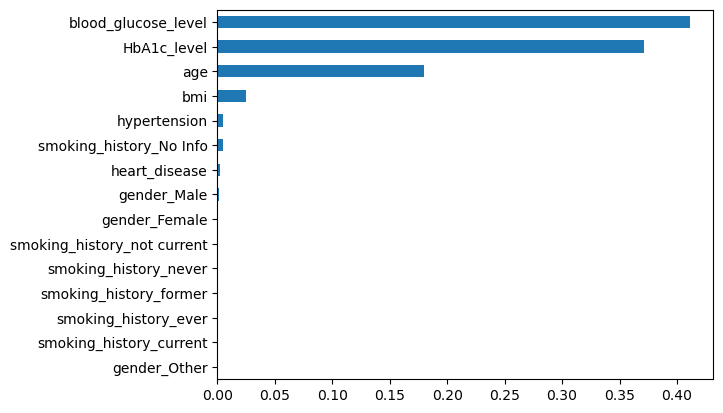

In [86]:
importances = dt.feature_importances_
importances
pd.Series(importances, index=feature_names).sort_values().plot(kind='barh')

# О данных

Датасет представляет собой набор медицинских и демографических данных пациентов, а также их диагноз по диабету (положительный или отрицательный). 

Данные включают такие характеристики, как возраст, пол, индекс массы тела (BMI), гипертония, болезни сердца, история курения, уровень HbA1c и уровень глюкозы в крови. Этот набор данных можно использовать для создания моделей машинного обучения для прогнозирования диабета у пациентов на основе их истории болезни и демографической информации.

# Submission задания

Вам будет предоставлен второй датасет, без целевой переменной (таргет - diabetes)
Этот датасет необходимо будет проскорить и сабмитнуть в Google Classroom в формате .csv, с 2 стобцами: `ID` и `prediction`

Поле `prediction` должно быть предсказанием **<span style = 'color : green'> класса </span>** (`predict`), т.е. 1 или 0 а **<span style = 'color : red'>не вероятности </span>** (`predict_proba`)

In [88]:
df_test = pd.read_csv('test_data.csv', index_col=0)

In [89]:
df_test

,ID,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,ba0d6256-ca6e-46a7-a2fb-2518a8937fd7,Female,60.0,1,0,former,23.77,4.8,130
1,7102b1ab-c7a4-4a43-b1fc-cb588d0553b8,Male,2.0,0,0,No Info,15.19,5.0,159
2,51ba207e-4934-41b4-a31c-cd275c5ca555,Female,74.0,0,0,not current,39.59,6.5,160
3,7e17faaa-0402-4728-9719-83982eba3afd,Female,51.0,0,0,never,26.67,6.6,80
4,08b4e515-286e-4393-9a55-138962f9546e,Male,35.0,0,0,never,26.09,3.5,159
...,...,...,...,...,...,...,...,...,...
26141,1f8db6fe-03f8-48ca-9a42-9f12062b002d,Female,31.0,0,0,never,27.32,6.1,140
26142,5bf3ca1a-ced5-474b-a354-cc3bec9f16d3,Female,65.0,1,1,never,27.25,5.7,100
26143,930e6345-a920-47dd-abd0-6bc0be2ae56f,Male,30.0,1,0,former,57.17,5.8,300
26144,035f3cc4-e8af-448a-8172-a1b027e06de1,Male,20.0,0,0,never,32.70,6.2,159


# Сбор данных с тестового

In [90]:
ohe = OneHotEncoder()
ohe_df = ohe.fit_transform(df_test[['gender', 'smoking_history']])
ohe_df = pd.DataFrame(ohe_df.toarray(), columns=ohe.get_feature_names_out())
df_test_2 = pd.concat([df_test, ohe_df], axis=1)
X_testing = df_test_2.drop(columns=['ID', 'gender', 'smoking_history']).values
df_test_2['prediction'] = dt.predict(X_testing)
df_test_2

,ID,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,prediction
0,ba0d6256-ca6e-46a7-a2fb-2518a8937fd7,Female,60.0,1,0,former,23.77,4.8,130,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,7102b1ab-c7a4-4a43-b1fc-cb588d0553b8,Male,2.0,0,0,No Info,15.19,5.0,159,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,51ba207e-4934-41b4-a31c-cd275c5ca555,Female,74.0,0,0,not current,39.59,6.5,160,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,7e17faaa-0402-4728-9719-83982eba3afd,Female,51.0,0,0,never,26.67,6.6,80,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,08b4e515-286e-4393-9a55-138962f9546e,Male,35.0,0,0,never,26.09,3.5,159,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26141,1f8db6fe-03f8-48ca-9a42-9f12062b002d,Female,31.0,0,0,never,27.32,6.1,140,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
26142,5bf3ca1a-ced5-474b-a354-cc3bec9f16d3,Female,65.0,1,1,never,27.25,5.7,100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
26143,930e6345-a920-47dd-abd0-6bc0be2ae56f,Male,30.0,1,0,former,57.17,5.8,300,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
26144,035f3cc4-e8af-448a-8172-a1b027e06de1,Male,20.0,0,0,never,32.70,6.2,159,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [92]:
df_conclusion = pd.DataFrame(df_test_2[['ID', 'prediction']])

In [93]:
df_conclusion

,ID,prediction
0,ba0d6256-ca6e-46a7-a2fb-2518a8937fd7,0
1,7102b1ab-c7a4-4a43-b1fc-cb588d0553b8,0
2,51ba207e-4934-41b4-a31c-cd275c5ca555,0
3,7e17faaa-0402-4728-9719-83982eba3afd,0
4,08b4e515-286e-4393-9a55-138962f9546e,0
...,...,...
26141,1f8db6fe-03f8-48ca-9a42-9f12062b002d,0
26142,5bf3ca1a-ced5-474b-a354-cc3bec9f16d3,0
26143,930e6345-a920-47dd-abd0-6bc0be2ae56f,1
26144,035f3cc4-e8af-448a-8172-a1b027e06de1,0


In [94]:
df_conclusion.to_csv('danial_data.csv')